
Using the SQL database approach, compare manta data with model results, varying
the averaging period and the max age.

**v01:** try adapting this to each category separately, see if the model shows difference in loss rates.

**v02:** use a single smoothing value (10), and generate more streamlined plots.

Manta data is already adjusted by category, and the category-level data is in the csv.

Load data...

In [272]:
import os
import time
from collections import defaultdict
import six

import logging as log
import glob
import re

import seaborn as sns
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import LogNorm

import numpy as np

import pandas as pd
import xarray as xr

from sqlite3 import dbapi2 as sql

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.spatial import proj_utils 
from stompy.model.data_comparison import calc_metrics
from stompy.plot import plot_wkb
from stompy.model import data_comparison
import stompy.plot.cmap as scmap
from scipy import stats


import postprocess_v00 as post

%matplotlib notebook

In [273]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')

In [274]:
# Load the manta data, clean it up
manta_fn='manta_summary-v02.csv'
manta=pd.read_csv(manta_fn)
manta.head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,CB-4-Manta-21Aug2017,CB4,2017-08-21 00:00:00,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21 00:00:00,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21 00:00:00,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21 00:00:00,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,CB9-Manta-22Aug2017,CB9,2017-08-22 00:00:00,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [4]:
import sql_common
six.moves.reload_module(sql_common)

# try to run everything that can be cached and re-used through
# here. 

<module 'sql_common' from '/home/rusty/src/microplastic_sfbay/postprocess/sql_common.py'>

In [5]:
#PtmSet=sql_common.PtmSet
#dbs=glob.glob("/opt2/sfb_ocean/ptm/all_source/*/ptm_and_grid.db")

PtmSet=sql_common.PtmSetNew
ptm_base="/opt2/sfb_ocean/ptm/all_source_021b"
dbs=glob.glob(os.path.join(ptm_base,"20*/ptm_and_grid.db")
dbs.sort()
ptm_set=PtmSet(databases=dbs)

In [6]:
# Get all of the group names so loads can be premapped
group_names=[]
for db in ptm_set.databases:
    con=ptm_set.db_to_con(db)
    curs=con.cursor()
    curs.execute("select name from ptm_group group by name")
    group_names.append( np.array([t[0] for t in curs.fetchall()],'S100') )
group_names=np.unique(np.concatenate(group_names)) # ensures sort, too
print(f"{len(group_names)} groups in total")

5831 groups in total


In [7]:
# For each trawl, I want to query all of the particles 
# that were "nearby" at a "near time", and get their
# release time, cell, std mass, and nofiber mass.
# from there, it's postprocessing to see what subset or
# weighting of those gives the best agreement with
# part_per_m2_std and part-per_m2_raw

In [15]:
# Is it possible to run the query once, and save enough info about the
# particles to apply loading scenarios after the fact?

def query_particles(t_start,t_stop,
                    z_filter="and loc.z_from_surface>-0.095",
                    max_age=np.timedelta64(20,'D'), # could go to 30
                    grp_filter=""):
    epoch_start=int( utils.to_unix( t_start ) )
    epoch_stop =int( utils.to_unix( t_stop ) )
    max_age_clause=f"and (loc.time-rel.time)<{int(max_age/np.timedelta64(1,'s'))}"

    # Start with a global query -- how long does it take, and how
    # many rows?
    # So rather than multiplying out the loads here, 
    # record rel.volume/rel.count to get rel_part_volume
    # 
    query=f"""
      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>={epoch_start} and loc.time < {epoch_stop}
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0
          {max_age_clause}
          {z_filter}
          {grp_filter}"""
    print(query)    
    
    query_dtype=[('rel_part_volume',np.float64),
                 ('time',np.int32),
                 ('rel_time',np.int32),
                 ('cell',np.int32),
                 ('group','S100')]

    all_data=[]
    all_data.append( np.zeros(0,dtype=query_dtype) )

    for db in ptm_set.databases:
        con=ptm_set.db_to_con(db)
        curs=con.cursor()
        curs.execute(query)
        data=curs.fetchall()
        print(f"{db} {len(data)} rows")
        if len(data)==0: continue
        adata=np.array(data)

        adata2=np.zeros(len(adata),dtype=query_dtype)
        adata2['rel_part_volume']=adata[:,0]
        adata2['time']=adata[:,1].astype(np.int32)
        adata2['rel_time']=adata[:,2].astype(np.int32)
        adata2['cell']=adata[:,3].astype(np.int32)
        adata2['group']=adata[:,4]
        all_data.append(adata2)

    combined=np.concatenate( all_data )
    return combined

In [16]:
# Load the loads
loads=xr.open_dataset("../loads/plastic_loads-7classes-v05.nc")
loads

<xarray.Dataset>
Dimensions:            (category: 6, pathway: 2, source: 9, w_s: 7)
Coordinates:
  * pathway            (pathway) object 'effluent' 'stormwater'
  * category           (category) object 'Fiber' 'Fiber Bundle' ... 'Sphere'
  * w_s                (w_s) float64 -0.05 -0.005 -0.0005 0.0 0.0005 0.005 0.05
  * source             (source) object 'CCCSD' 'EBDA' ... 'SUNN' 'stormwater'
Data variables:
    n_blank_particles  (pathway, category) int64 ...
    n_blank_samples    (pathway, category) int64 ...
    blank_rate         (pathway, category) float64 ...
    total_volume       (source) float64 ...
    n_samples          (source) float64 ...
    count_w_s          (source, category, w_s) int32 ...
    count_no_w_s       (source, category) int32 ...
    conc_raw           (source, category, w_s) float64 ...
    source_pathway     (source) object ...
    conc               (source, category, w_s) float64 ...
    conc_noclip        (source, category, w_s) float64 ...
    conc_

In [17]:
# res: released_part_volume particles/m3, time of observation, release_time, cell index,
# and the group.
# loads: source, category, w_s => particles/l
# Note that wastewater should be scaled up by 1/0.70
# stormwater is maybe close enough now that there are so many sources.
behavior_to_ws=sql_common.behavior_to_ws
# allow for unicode or byte strings
for k in list(behavior_to_ws.keys()):
    behavior_to_ws[k.encode()]=behavior_to_ws[k]

source_map=defaultdict(lambda:'stormwater')                                                                                                                
source_map['cccsd']='CCCSD'                                                                                                                                
source_map['sunnyvale']='SUNN'                                                                                                                             
source_map['fs']='FSSD'                                                                                                                                    
source_map['palo_alto']='PA'                                                                                                                               
source_map['san_jose']='SJ'                                                                                                                                
source_map['src000']='EBDA'                                                                                                                                
source_map['src001']='EBMUD'                                                                                                                               
source_map['src002']='SFPUC'                                                                                                                               

# these we don't actually use                                                                                                                              
source_map['petaluma']='SKIP'                                                                                                                              

# These shouldn't be used, but including just to be sure                                                                                                   
# that if they somehow show up, they won't contaminate                                                                                                     
# stormwater.                                                                                                                                              
source_map['SacRiver']='DELTA'                                                                                                                             
source_map['SJRiver']='DELTA'                                                                                                                              

def particle_load_mapping(load_da,group_names,wastewater_scale=1/0.70,stormwater_scale=1.0):
    # Here generate a mapping of group to release particle/m3.
    # tuples of group_name, particles/m3.                                                                                                                      
    # can omit rows with 0 concentration.                                                                                                                      
    
    # numpy strings have to be preallocated at max string length.
    # thus S100.  S is a few times faster for numpy to deal with
    # than U.
    mapping=np.zeros(len(group_names),
                     dtype=[('group','S100'),('conc',np.float64)])
    mapping['group'][:]=group_names
    
    for grp_i, group_name in enumerate(group_names):
        # group ~ Source_Name_behavior_relYYYYMMDD
        # and note the 'b' here, since using S-types and not U-types
        m=re.match(b'(.*)_(down\d+|up\d+|none)(_rel.*)?',group_name)                                                                                         
        source=m.group(1)  
        behavior=m.group(2)
        rel_time=m.group(3) # may be missing
        w_s=behavior_to_ws[behavior]                                                                                                                           

        source_name=source_map[source]                                                                                                                         
        if source_name in ['DELTA','SKIP']:                                                                                                                    
            conc=0.0                                                                                                                              
        else:                                                                                                                                                  
            conc=load_da.sel(source=source_name,w_s=w_s).item()                                                                                           

        if source_name=='stormwater':                                                                                                
            conc*=stormwater_scale                                                                                                                             
        else:                                                                                                                                                  
            conc*=wastewater_scale                                                                                                                             

        # load netcdf is in particles/l, but we want to set the calculation                                                                                    
        # up as particle/m3. Updated 2019-11-17                                                                                                                
        conc*=1000                                                                                                                                                                                                                                                                                       
        mapping['conc'][grp_i]=conc
        # print(f"{source:15s}  {behavior:9s} => {source_name:15s} {conc:.4f}")
    return mapping

def particle_counts_from_load(res,mapping,**kw):
    """
    load_da: xr.DataArray giving microparticle/m3 load concentrations
    by source and w_s.
    res: numpy struct array with group: <Source>_<w_s>_<release date>
      and rel_part_volume: the inflow volume represented by each PTM particle.
    return an array, same size as res, giving the inflow count of microparticles
      for each PTM particle. 
    """
    # This may still be slow:
    grp_idx=np.searchsorted(mapping['group'],res['group'])

    # microparticles/m3 in the release for each PTM particle
    load_conc=mapping['conc'][grp_idx]
    # microparticles/PTM particle.
    load_particles=load_conc * res['rel_part_volume']
    return load_particles


In [18]:
out_dir="manta_sets_20200212c"
# now the 021b runs.
# c suffix: use tighter -0.095 z filter.

os.makedirs(out_dir,exist_ok=True)

for idx,rec in manta.iterrows():
    #fn=os.path.join(out_dir,f"{rec.SampleID}.npy")
    # since we're just pulling out whole days, cache by day.
    # and pull through the end of that day
    fn=os.path.join(out_dir,f"v01-{rec.DATE[:10]}.npy")
    
    if os.path.exists(fn):
        print(f"{fn} exists. Skipping")
        continue

    # pull a generous buffer of particles here, and narrow
    if 1:
        t_sample=np.datetime64(rec.DATE)
        # want to be able to, after the fact, query a full 25h tidal cycle
        # centered on the actual time of a sample that could fall anywhere
        # in this day.
        t_start=t_sample+np.timedelta64(8,'h') - np.timedelta64(12,'h')
        # and go for a tidal day
        t_stop =t_sample+np.timedelta64(8+24,'h') + np.timedelta64(13,'h')
        query_n_steps=25 # how many hours are included in the query.
        
    combined=query_particles(t_start,t_stop)
    np.save(fn,combined)



      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>=1503259200 and loc.time < 1503435600
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0
          and (loc.time-rel.time)<1728000
          and loc.z_from_surface>-0.095
          
/opt2/sfb_ocean/ptm/all_source_021b/20170720/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170730/ptm_and_grid.db 566460 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170809/ptm_and_grid.db 756098 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170819/ptm_and_grid.db 339052 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170829/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170908/ptm_and_grid.db 0 rows
/opt2/sfb_o

/opt2/sfb_ocean/ptm/all_source_021b/20170730/ptm_and_grid.db 337233 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170809/ptm_and_grid.db 751361 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170819/ptm_and_grid.db 683476 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170829/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170908/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170918/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170928/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171008/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171018/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171028/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171107/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171117/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171127/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171207/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_02

/opt2/sfb_ocean/ptm/all_source_021b/20170819/ptm_and_grid.db 338222 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170829/ptm_and_grid.db 853571 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170908/ptm_and_grid.db 685927 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170918/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20170928/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171008/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171018/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171028/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171107/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171117/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171127/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171207/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171217/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171227/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_02

/opt2/sfb_ocean/ptm/all_source_021b/20171028/ptm_and_grid.db 1527746 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171107/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171117/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171127/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171207/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171217/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171227/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180106/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180116/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180126/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180205/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180215/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180225/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180307/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/201803

/opt2/sfb_ocean/ptm/all_source_021b/20171217/ptm_and_grid.db 759860 rows
/opt2/sfb_ocean/ptm/all_source_021b/20171227/ptm_and_grid.db 1930431 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180106/ptm_and_grid.db 1551529 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180116/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180126/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180205/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180215/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180225/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180307/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180317/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180327/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180406/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180416/ptm_and_grid.db 0 rows
manta_sets_20200212c/v01-2018-01-11.npy exists. Skipping
manta_sets_20200212c/v01-2018-01-11.npy ex

/opt2/sfb_ocean/ptm/all_source_021b/20180307/ptm_and_grid.db 1090250 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180317/ptm_and_grid.db 1548919 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180327/ptm_and_grid.db 658911 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180406/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_021b/20180416/ptm_and_grid.db 0 rows
manta_sets_20200212c/v01-2018-03-29.npy exists. Skipping
manta_sets_20200212c/v01-2018-03-29.npy exists. Skipping
manta_sets_20200212c/v01-2018-03-29.npy exists. Skipping

      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>=1522353600 and loc.time < 1522530000
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0

In [19]:
g=ptm_set.grid()

In [20]:
@memoize.memoize(lru=60)
def load_particles_with_load(date,mapping):
    particle_fn=os.path.join(out_dir,f"v01-{date[:10]}.npy")
    particles=np.load(particle_fn)
    
    grp_idx=np.searchsorted(mapping['group'],particles['group'])
    # Be sure matches are exact!
    assert np.all( mapping['group'][grp_idx]==particles['group'])
    
    load_conc=mapping['conc'][grp_idx]
    # microparticles/PTM particle.
    load_particles=load_conc * particles['rel_part_volume']
    p=utils.recarray_add_fields(particles,[ ('load_count',load_particles)])
    return p

In [21]:
@memoize.memoize()
def stencil0(c):
    stencil=np.zeros(g.Ncells(),np.float64)
    stencil[c]=1.0
    return stencil

@memoize.memoize()
def stencil1(c):
    return ptm_set.smooth(stencil0(c))
   

In [22]:
import time

# which particles will be counted relative to the time of the manta
# observation itself.
vers='20200214e' # 25 h, centered on sample. Thinner sample.
hours_min=-12
hours_max= 13

# previous attempts
#vers='20191205e' # 6 h, centered on sample. not as clear, but 1d is still the winner.
#hours_min=-3
#hours_max= 3

#vers='20191205f' # 4 h, centered on sample. not great, and 0.5d is the winner.
#hours_min=-2
#hours_max= 2

def extract_for_sample(rec,mapping,smooth=0,tau_s=-1):
    """
    rec: a DataFrame row from the manta data
    load_da: xr.DataArray with particle/m3 load concentrations by source, w_s.
    """
    t0=time.time()
    def tok(msg=''):
        print(f"{msg} elapsed {time.time()-t0}")

    # This is where a different wastewater_scale or stormwater_scale
    # could be supplied  with some effort.
    particles=load_particles_with_load(rec.DATE,mapping)
    
    age_s=particles['time']-particles['rel_time']
    if tau_s>0:
        aged_counts=np.exp(-age_s/tau_s) * particles['load_count']
    else:
        aged_counts=load_counts
        
    # time of observation relative to the time of the manta sample.
    relative_time_h=(particles['time']-utils.to_unix(rec.time_utc))/3600.0
    aged_counts[relative_time_h<hours_min]=0.0
    aged_counts[relative_time_h>hours_max]=0.0
    nsteps=hours_max-hours_min

    cell_counts=np.bincount( particles['cell'], weights=aged_counts,
                             minlength=g.Ncells())
    # This sets the units -- particles per m2
    cell_conc=cell_counts/g.cells_area()/nsteps

    c_select=ptm_set.grid().select_cells_nearest(np.r_[rec.x,rec.y])
    stencil=stencil0(c_select)
    M=ptm_set.Msmooth()
    for s in range(smooth):
        stencil=M.dot(stencil)
    conc=(stencil*cell_conc).sum()
    return conc

In [59]:
# These need to be consistent with each other:
# full dataset:

if 0:
    #   spearman is almost constant.
    #   log_r shows mostly a smooth=2 signal, but not that much variation.
    #   r has a great pattern. but the values are about 0.25, and it's almost
    #     certainly driven by a few large values, so not that convincing.
    manta_field='part_per_m2_std'
    load_da=loads.conc.sum(dim='category')
    sub_vers=vers+"std"
if 1:
    # non-fibers:
    #   quite similar to previous code.  tau=2 from pearson or log-r.
    #   amp suggests 1.0d, but the manta size class issue easily justifies
    #   saying this could be 2.0days.
    manta_field='part_per_m2_nofiber'
    # TODO: the above actually includes Fiber Bundles, which probably ought to
    # be omitted with fibers.  for some data, Fiber Bundles were not counted 
    # separate from fibers.
    load_sel=(loads.category.values != 'Fiber')&(loads.category.values!='Fiber Bundle')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"nofiber"
if 0:
    # films - pretty terrible.  amplitude suggests 3-4 days.
    # correlations are screwy, and show the worst correlations at
    # that same time scale.
    manta_field='part_per_m2_film'
    manta[manta_field]=manta['Fiber_adj']/manta['area_m2']
    load_sel=(loads.category.values == 'Film')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"film"
if 0:
    # fragments - this one does look quite similar to the nofiber
    # data.  amplitude ~ 1 day, spearman ~ 3 days
    manta_field='part_per_m2_fragment'
    manta[manta_field]=manta['Fragment_adj']/manta['area_m2']
    load_sel=(loads.category.values == 'Fragment')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"fragment"
if 0:
    # just fibers!  spearman says shortest tau, least smoothing
    # log(amp) says a bit less than 1 day.
    # wilmott says 0.5 days
    manta_field='part_per_m2_fiber'
    manta[manta_field]=(manta['Fiber_adj']+manta['Fiber Bundle_adj'])/manta['area_m2']
    load_sel=(loads.category.values == 'Fiber')|(loads.category.values=='Fiber Bundle')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"fiber"
if 0:
    # foam - spearman says full smoothing, shortest tau
    # amplitude says 1-2 days
    manta_field='part_per_m2_foam'
    manta[manta_field]=manta['Foam_adj']/manta['area_m2']
    load_sel=(loads.category.values == 'Foam')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"foam"
if 0:
    # sphere
    manta_field='part_per_m2_sphere'
    manta[manta_field]=manta['Sphere_adj']/manta['area_m2']
    load_sel=(loads.category.values == 'Sphere')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"sphere"
    
smooths=[10] # abbreviated to speed things up.
taus=np.array([0.5,1,2,3,4,5,7.5,10,15,20]) * 86400.
#smooths=[5]
#taus=taus[2:3]

mapping=particle_load_mapping(load_da,group_names)

all_results=[]

per_trawls=[]

for smooth in smooths:
    for tau in taus:
        # 1 or 2 smooth makes a big improvement in spearman.
        # nothing helps r, bias or amp.
        pred=[]
        for idx,rec in utils.progress(manta.iterrows()):
            if np.isnan(rec[manta_field]):
                # e.g. sample did not test for fibers, but manta_field and
                # loads include fibers.
                x=np.nan
            else:
                x=extract_for_sample(rec,mapping=mapping,smooth=smooth,tau_s=tau)
            pred.append(x)
        pred=np.array(pred)
        obs=manta[manta_field]

        per_trawl=manta.copy()
        per_trawl['predicted']=pred
        per_trawls.append(per_trawl)
        
        valid=np.isfinite(obs)
        pred=pred[valid]
        obs=obs[valid]
        
        metrics=calc_metrics( xr.DataArray(pred), xr.DataArray(obs))
        metrics['smooth']=smooth
        metrics['tau']=tau
        metrics['dataset']=sub_vers
        
        metrics['log_r']=np.corrcoef( np.log10(pred.clip(1e-6)), np.log10(obs.clip(1e-6)))[1,0]
        all_results.append(metrics)

df=pd.DataFrame(all_results)
df.to_csv(f"parameter-scan-{sub_vers}.csv")

INFO:utils:18
INFO:utils:33
INFO:utils:45
INFO:utils:58
INFO:utils:47
INFO:utils:47
INFO:utils:47
INFO:utils:47
INFO:utils:47
INFO:utils:47
INFO:utils:47
INFO:utils:47
INFO:utils:47


In [276]:
df=pd.read_csv(f'parameter-scan-{sub_vers}.csv')
df['tau_d']=df.tau/86400.

In [279]:
df['log_r2']=df.log_r**2
df.loc[:,['amp','log_r2','murphy','r','spearman_rho','tau_d']]

,amp,log_r2,murphy,r,spearman_rho,tau_d
0,0.221041,0.251618,0.073511,0.291946,0.533856,0.5
1,0.700058,0.302279,-0.258429,0.197080,0.558682,1.0
2,2.757465,0.341168,-8.985742,0.078865,0.595439,2.0
3,8.015159,0.344634,-75.995364,0.027110,0.587834,3.0
4,16.215592,0.336690,-304.871447,0.009876,0.588009,4.0
5,25.947369,0.329469,-773.137063,0.002673,0.570657,5.0
6,51.204752,0.319825,-2987.239869,-0.004016,0.549766,7.5
7,73.596589,0.315308,-6159.878626,-0.006374,0.544390,10.0
8,107.439887,0.310225,-13119.869480,-0.008210,0.532676,15.0
9,130.583304,0.307519,-19382.924295,-0.008960,0.525159,20.0


In [ ]:
df['log_]

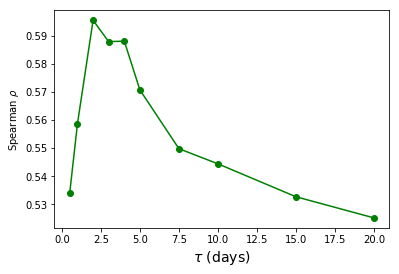

In [268]:
field='spearman_rho'
nice_field=r'Spearman $\rho$'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

fig,ax=plt.subplots(1,1)
if len(smooths)>1:
    hm=sns.heatmap(as_matrix, annot=True)
    ax.set_ylabel('Smoothing iterations',fontsize=14)
    cax=fig.axes[1]
    cax.set_ylabel(nice_field,fontsize=14)
    plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
else:
    ax.plot(df['tau_d'],df[field],'g-o')
    ax.set_ylabel(nice_field)
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
fig.savefig(f'manta_compare_spearman_rho-{sub_vers}.png',dpi=200)

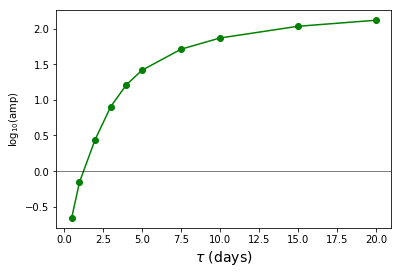

In [269]:
df['log_amp']=np.log10(df.amp)
field='log_amp'
nice_field='log$_{10}$(amp)'


fig,ax=plt.subplots(1,1)
if len(smooths)>1:
    as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()
    hm=sns.heatmap(as_matrix, annot=True,cmap='coolwarm',ax=ax,
                   cbar_kws=dict(label=field),vmin=-1,vmax=1)
    plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
    ax.set_ylabel('Smoothing iterations',fontsize=14)
    cax=fig.axes[1]
    cax.set_ylabel(nice_field,fontsize=14)
else:
    ax.plot(df['tau_d'],df[field],'g-o')
    ax.set_ylabel(nice_field)
    ax.axhline(0,color='k',lw=0.5)
    
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
fig.savefig(f'manta_compare_log10amp-{sub_vers}.png',dpi=200)


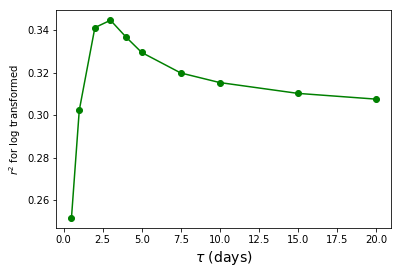

In [271]:
field='log_r'
nice_field='$r^2$ for log transformed'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

fig,ax=plt.subplots(1,1)
if len(smooths)>1:
    hm=sns.heatmap(as_matrix**2, annot=True)
    ax.set_ylabel('Smoothing iterations',fontsize=14)
    cax=fig.axes[1]
    cax.set_ylabel(nice_field,fontsize=14)
    plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
else:
    ax.plot(df['tau_d'],df[field]**2,'g-o')
    ax.set_ylabel(nice_field)
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
fig.savefig(f'manta_compare_log_r2-{sub_vers}.png',dpi=200)



<IPython.core.display.Javascript object>


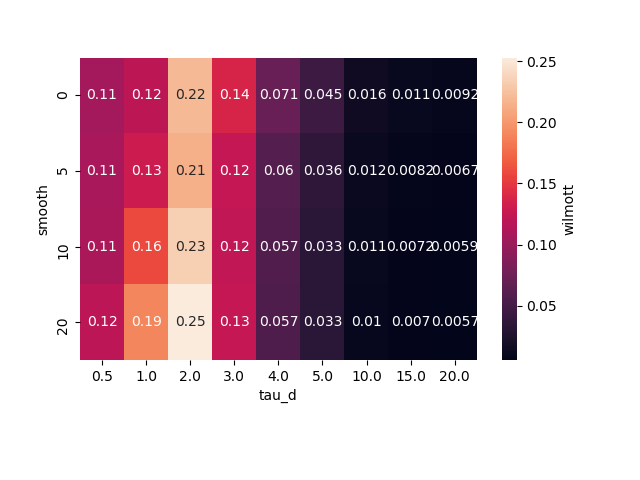

In [295]:
field='wilmott'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

<IPython.core.display.Javascript object>


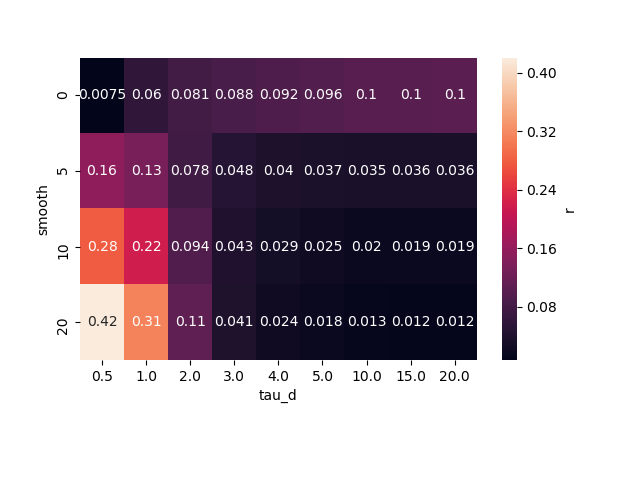

In [296]:
field='r'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

<IPython.core.display.Javascript object>


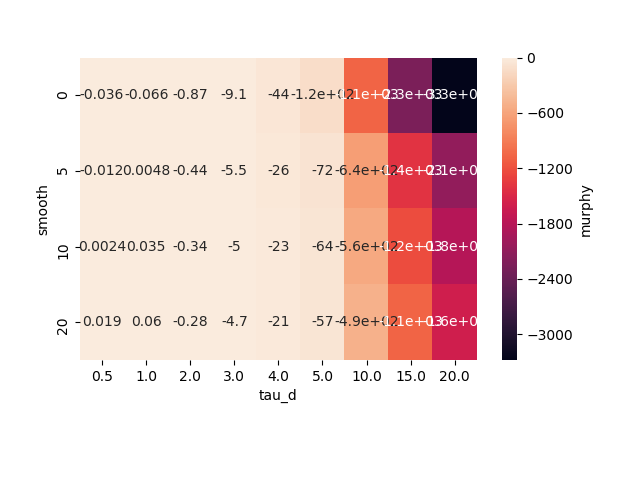

In [297]:
field='murphy'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

In [213]:
# Scatter for a specific case:
manta_field='part_per_m2_std'
load_da=loads.conc.sum(dim='category')

smooth=20
tau=2 * 86400.
mapping=particle_load_mapping(load_da,group_names)

all_results=[]
pred=[]
for idx,rec in utils.progress(manta.iterrows()):
    if np.isnan(rec[manta_field]):
        # e.g. sample did not test for fibers, but manta_field and
        # loads include fibers.
        x=np.nan
    else:
        x=extract_for_sample(rec,mapping=mapping,smooth=smooth,tau_s=tau)
    pred.append(x)
pred=np.array(pred)
obs=manta[manta_field]

valid=np.isfinite(obs)
pred=pred[valid]
obs=obs[valid]

INFO:utils:46


<IPython.core.display.Javascript object>


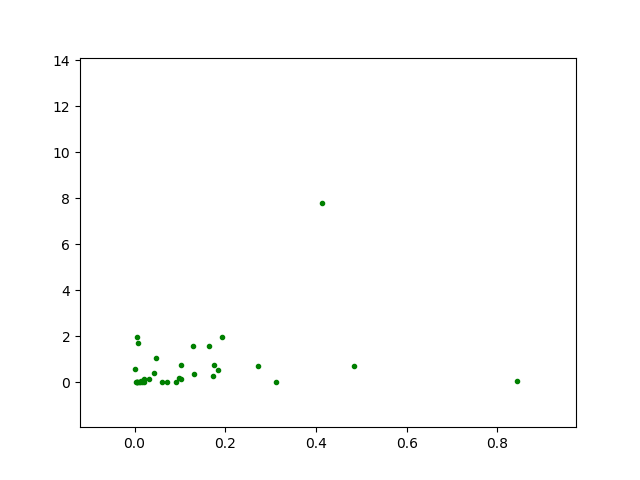

In [214]:
fig,ax=plt.subplots(1,1)
ax.plot(obs,pred,'g.')

In [215]:
np.corrcoef(obs,pred)

array([[1.        , 0.28083222],
       [0.28083222, 1.        ]])

In [ ]:

# for baseline reference, what concentration do I get
# from this directly?
cell_counts=np.zeros(g.Ncells(),np.float64)
for count,time,rel_time,cell in combined:
    cell_counts[int(cell)]+=count
nsteps=4 # [-2,+2] hours
cell_conc=cell_counts/g.cells_area()/nsteps

In [ ]:
fig=plt.figure()
ax=plt.gca()

clim=[1e-4,100]
ccoll=g.plot_cells(values=cell_conc.clip(clim[0]),
                   norm=LogNorm(vmin=clim[0],vmax=clim[1],clip=True),
                   cmap='jet',ax=ax)
ccoll.set_clim(clim)
ax.axis('equal')

In [ ]:
# relate that back to the sample:
c_select=ptm_set.grid().select_cells_nearest(np.r_[rec.x,rec.y])

stencil=np.zeros(g.Ncells(),np.float64)
stencil[c_select]=1.0
stencil1=ptm_set.smooth(stencil)
conc0=(stencil*cell_conc).sum()
conc1=(stencil1*cell_conc).sum()

print(f"No smoothing, predicted: {conc0:.5f} particles/m2")
print(f"Smoothed, predicted      {conc1:.5f} particles/m2")
print(f"Observed, no-fiber       {rec['part_per_m2_nofiber']:.5f} particles/m2")

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.loglog( obs, pred, 'g.',ms=7 )

ax.set_ylabel('Model')
ax.set_xlabel('Observed')
fig.tight_layout()
fig.savefig('scatter-depression.png',dpi=150)

In [ ]:
pred=manta.apply(lambda rec: extract_for_sample(rec,smooth=10,tau_s=2*86400),
                 axis=1)
obs=manta['part_per_m2_nofiber']

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.loglog( obs, pred, 'g.',ms=7 )

ax.set_ylabel('Model')
ax.set_xlabel('Observed')
fig.tight_layout()
fig.savefig('scatter-betterest.png',dpi=150)

In [ ]:
np.corrcoef(np.log10(obs.clip(1e-5)),
            np.log10(pred.clip(1e-5)))

In [63]:
# Any improvement by aggregating trawls?
per_trawls[0].head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y,part_per_m2_film,part_per_m2_fragment,part_per_m2_fiber,part_per_m2_foam,part_per_m2_sphere,predicted
0,CB-4-Manta-21Aug2017,CB4,2017-08-21 00:00:00,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,0.024841,0.002360,550040.331073,4.198063e+06,0.019823,0.001475,0.019823,0.000000,0.000000,0.007316
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21 00:00:00,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,0.301706,0.028662,557329.971756,4.209634e+06,0.144505,0.018899,0.144505,0.001881,0.000239,0.010339
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21 00:00:00,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,0.039205,0.003724,582363.556136,4.217527e+06,0.000000,0.000039,0.000000,0.003065,0.000000,0.034116
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21 00:00:00,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,0.034288,0.003257,550464.046320,4.210092e+06,0.017915,0.002087,0.017915,0.000000,0.000000,0.000005
4,CB9-Manta-22Aug2017,CB9,2017-08-22 00:00:00,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,0.091677,0.008709,562183.425087,4.171973e+06,0.000000,0.007004,0.000000,0.000000,0.000581,0.187850


In [116]:
taus/86400.

array([ 0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  7.5, 10. , 15. , 20. ])

Tau: 0.5
P-total: 0.001  with scale: 0.316228
0.5 days: ampl. error: 0.316 Median test net p: 0.00120

Tau: 1.0
P-total: 0.007  with scale: 3.981072
1.0 days: ampl. error: 3.981 Median test net p: 0.00708

Tau: 2.0
P-total: 0.007  with scale: 15.848932
2.0 days: ampl. error: 15.849 Median test net p: 0.00708

Tau: 3.0
P-total: 0.127  with scale: 9.440609
3.0 days: ampl. error: 9.441 Median test net p: 0.12725

Tau: 4.0
P-total: 0.165  with scale: 23.173946
4.0 days: ampl. error: 23.174 Median test net p: 0.16537

Tau: 5.0
P-total: 0.319  with scale: 31.622777
5.0 days: ampl. error: 31.623 Median test net p: 0.31881

Tau: 7.5
P-total: 0.441  with scale: 63.095734
7.5 days: ampl. error: 63.096 Median test net p: 0.44054

Tau: 10.0
P-total: 0.441  with scale: 100.000000
10.0 days: ampl. error: 100.000 Median test net p: 0.44054

Tau: 15.0
P-total: 0.441  with scale: 100.000000
15.0 days: ampl. error: 100.000 Median test net p: 0.44054

Tau: 20.0
P-total: 0.441  with scale: 125.892541
20.0

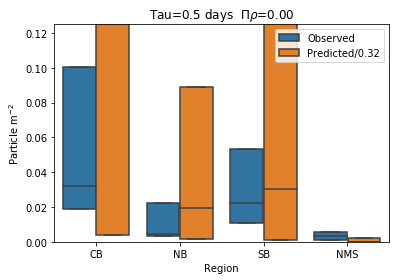

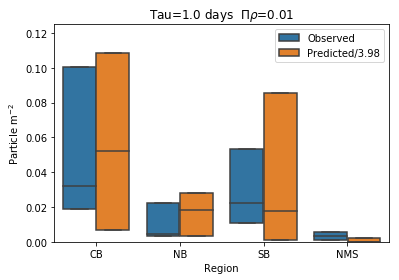

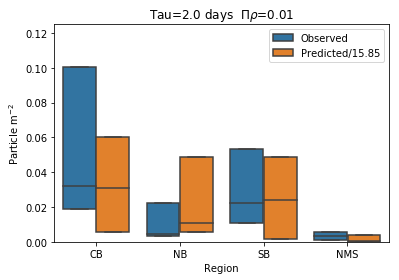

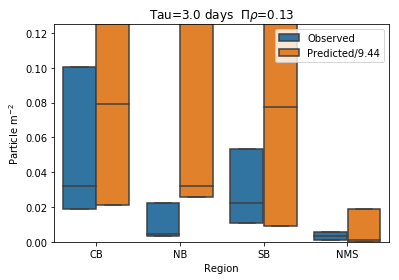

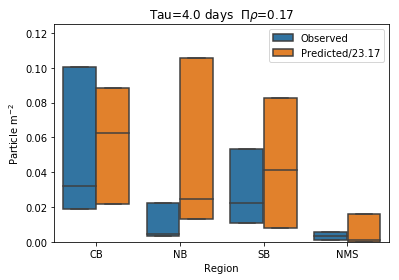

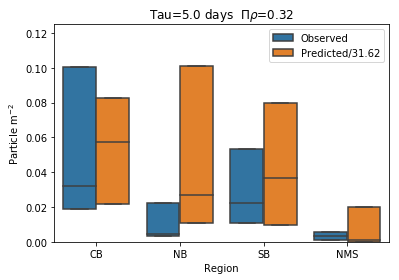

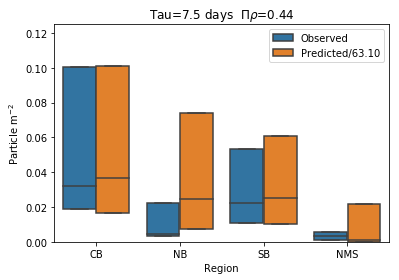

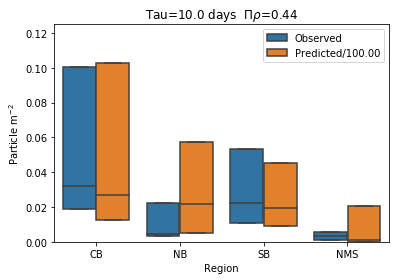

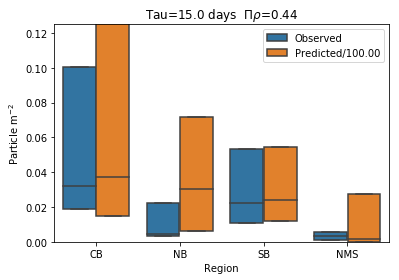

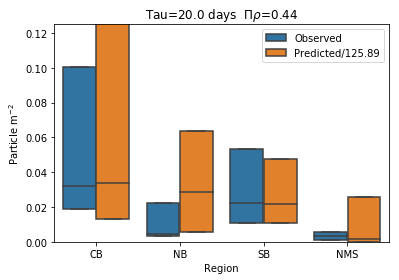

In [263]:
# Group samples - Central Bay, North Bay, South Bay, NMS.
def loc_to_region(s):
    if s.startswith('SPB') or s.startswith('SUB'): return 'NB'
    if s.startswith('SB') or s.startswith('LSB'): return 'SB'
    if s.startswith('GFNMS') or s.startswith('MBNMS') or s.startswith('CBNMS'): 
        return 'NMS'
    if s.startswith('CB') or s=='SFBay': return 'CB'
    raise Exception("No match for %s"%s)
    
for tau,df in zip(taus,per_trawls):
    print(f"Tau: {tau/86400.}")
    regions=df['region']=df['SAMPLE LOCATION'].apply(loc_to_region)
    df=df.rename(columns={manta_field:'obs'}).loc[:,['region','obs','predicted']]

    # Scale gets optimized to find the best nonparametric match
    p_tot,scale=analyze_medians(df)

    # This is not rigorous!
    obs_mag=1.0
    pred_mag=1/scale
    
    df['obs_frac']=df['obs'] / obs_mag
    df['pred_frac']=df['predicted'] / pred_mag

    dfm=df.loc[:,['region','obs_frac','pred_frac']].melt(id_vars=['region'])

    fig,ax=plt.subplots(1,1)# ,figsize=(10,3))
    sns.boxplot(x='region',y='value',hue='variable',data=dfm,fliersize=0,whis=0,
                ax=ax,bootstrap=1000)
    ax.axis(ymax=0.125,ymin=0)
    ax.legend(ax.artists,['Observed',f'Predicted/{pred_mag:.2f}'],loc='upper right')
    ax.set_ylabel('Particle m$^{-2}$')
    ax.set_xlabel('Region')
    
    ax.set_title(f'Tau={tau/86400.} days  $\\Pi \\rho$={p_tot:.2f}')
    df2=dfm.set_index(['region','variable'])
    p_tot=1.0
    for region in ['CB','NB','SB','NMS']:
        stat,p,M,cont=stats.median_test( df2.loc[ (region,'obs_frac'), 'value'] ,
                                         df2.loc[ (region,'pred_frac'), 'value'] )
        p_tot*=p
    print(f"{tau/86400.} days: ampl. error: {pred_mag/obs_mag:.3f} Median test net p: {p_tot:.5f}")
    
    print()
    fig.savefig(f'manta_comp_v02-tau{tau/86400}.png',dpi=200)

In [252]:
def analyze_medians(df):
    dfm=df.loc[:,['region','obs','predicted']].melt(id_vars=['region']).set_index(['region','variable'])

    dfm.sort_index(inplace=True)

    def p_total(f):
        # Maximize the combined median test
        p_tot=1.0
        for region in ['CB','NB','SB','NMS']:
            stat,p,M,cont=stats.median_test( dfm.loc[ (region,'obs'), 'value'] ,
                                             f*dfm.loc[ (region,'predicted'), 'value'] )
            p_tot*=p
        return p_tot

    def cost(p):
        return -p_total( 10**p )

    from scipy.optimize import brute

    best=brute(cost,[[-4,1]],Ns=51)
    scale=10**best[0]
    p_tot=p_total(scale)
    print(f"P-total: {p_tot:.3f}  with scale: {1/scale:5f}")
    return p_tot,scale